In [26]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [42]:
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from helper_functions import accuracy_fn

In [28]:
train_data = FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = FashionMNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [43]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [32]:
img, label = train_data[0]
class_names = train_data.classes


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

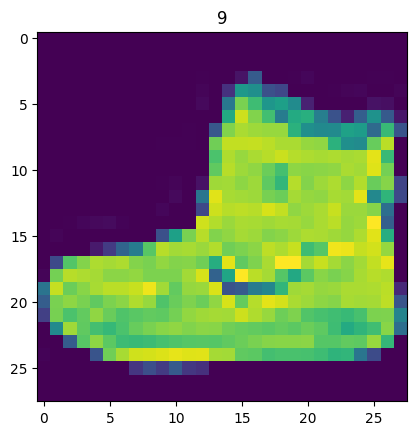

In [34]:
plt.imshow(img.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

In [35]:
img.shape

torch.Size([1, 28, 28])

In [38]:

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [55]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer(x)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
def train_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             accuracy_fn,
             device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(dataloader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [57]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    # Send data to GPU
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred

    # Adjust metrics and print out
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [52]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [58]:
epochs = 3
train_time_start_on_gpu = timer()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(dataloader=train_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(dataloader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.47770 | Train accuracy: 83.18%
Test loss: 0.48906 | Test accuracy: 82.50%

Epoch: 1
---------
Train loss: 0.45621 | Train accuracy: 84.05%
Test loss: 0.48784 | Test accuracy: 83.11%

Epoch: 2
---------
Train loss: 0.44433 | Train accuracy: 84.35%
Test loss: 0.51892 | Test accuracy: 82.69%

Train time on cpu: 36.367 seconds


In [88]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
epochs = 3
train_time_start_on_gpu = timer()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(dataloader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(dataloader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


In [61]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [71]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

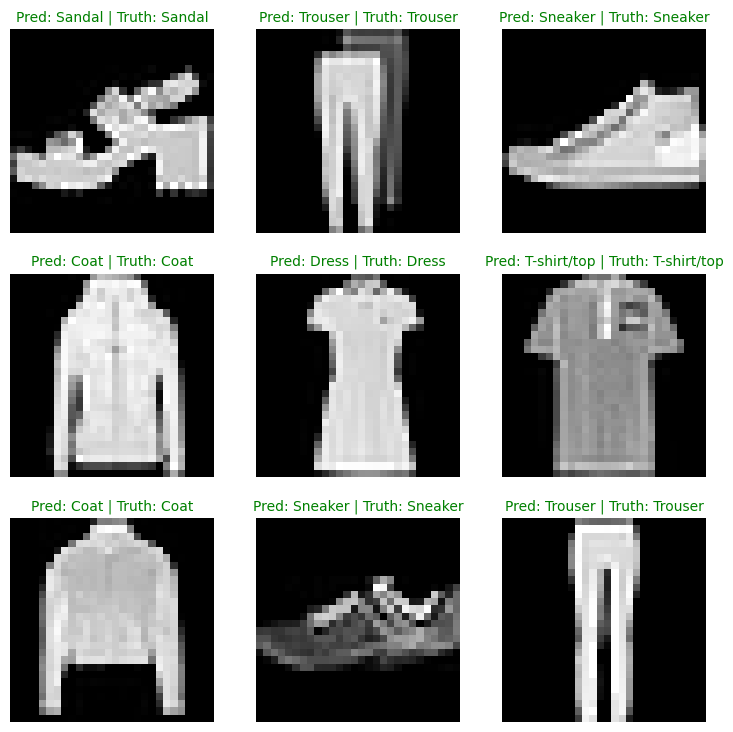

In [72]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);